In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.metrics import confusion_matrix, cohen_kappa_score

RATERS = {'JC', 'AS', 'GL'}

raters_dir = "/Users/gioli/projects/stateswitch/data/rec/svf_ratings/"

def load_ratings(file_path):
    """Load ratings from a xlsx file into a pandas DataFrame."""
    df = pd.read_excel(file_path, engine='openpyxl')
    # Forward-fill category column to handle NaN values
    if 'category' in df.columns:
        df['category'] = df['category'].ffill()
    return df

def load_ratings_by_rater(rater: str) -> dict[str, pd.DataFrame]:
    """Load ratings for a specific rater from corresponding folder."""
    if rater not in RATERS:
        raise ValueError(f"Rater '{rater}' is not recognized. Valid raters are: {RATERS}")
    rater_dir = os.path.join(raters_dir, rater)
    xlsx_files = [f for f in os.listdir(rater_dir) if f.endswith('.xlsx')]
    ratings_session = {}
    for file in xlsx_files:
        session_name = file.split('_task-svf')[0]
        file_path = os.path.join(rater_dir, file)
        ratings_session[session_name] = load_ratings(file_path)
    return ratings_session

def load_all_ratings() -> dict[str, dict[str, pd.DataFrame]]:
    """Load ratings from all raters."""
    all_ratings = {}
    for rater in RATERS:
        try:
            all_ratings[rater] = load_ratings_by_rater(rater)
        except FileNotFoundError:
            print(f"Warning: Directory for rater '{rater}' not found.")
    return all_ratings

def get_all_sessions(all_ratings: dict) -> set:
    """Get all unique sessions across all raters."""
    sessions = set()
    for rater, rater_sessions in all_ratings.items():
        sessions.update(rater_sessions.keys())
    return sessions

def get_shared_sessions(all_ratings: dict, raters: list = None) -> set:
    """Get sessions that are rated by all specified raters."""
    if raters is None:
        raters = list(all_ratings.keys())
    
    session_sets = [set(all_ratings[r].keys()) for r in raters if r in all_ratings]
    if not session_sets:
        return set()
    
    return set.intersection(*session_sets)

def filter_for_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter DataFrame for analysis by excluding:
    - 'next' marker rows
    - First word of each category
    Returns a filtered copy, does not modify original.
    """
    # Exclude 'next' markers
    mask = df['word'] != 'next'
    
    # Exclude first word of each category
    is_first_in_category = df['category'] != df['category'].shift(1)
    mask = mask & ~is_first_in_category
    
    return df[mask]

def align_ratings_by_word(all_ratings: dict, session: str) -> pd.DataFrame:
    """
    Align ratings from different raters for the same session by word.
    Uses (category, word, start) as a unique identifier for each item.
    """
    dfs = []
    for rater, sessions in all_ratings.items():
        if session in sessions:
            df = sessions[session].copy()
            df = filter_for_analysis(df)
            df = df.rename(columns={'switch_flag': f'switch_flag_{rater}'})
            df = df[['category', 'word', 'start', f'switch_flag_{rater}']]
            dfs.append(df)
    
    if len(dfs) < 2:
        raise ValueError(f"Need at least 2 raters for session '{session}', found {len(dfs)}")
    
    merged = dfs[0]
    for df in dfs[1:]:
        merged = pd.merge(merged, df, on=['category', 'word', 'start'], how='outer')
    
    return merged

def align_ratings_all_sessions(all_ratings: dict) -> pd.DataFrame:
    """
    Align ratings from all raters across all sessions.
    Returns a single DataFrame with session as an additional column.
    """
    all_aligned = []
    sessions = get_all_sessions(all_ratings)
    
    for session in sessions:
        raters_with_session = [r for r in all_ratings if session in all_ratings[r]]
        if len(raters_with_session) < 2:
            continue
        
        try:
            aligned = align_ratings_by_word(all_ratings, session)
            aligned['session'] = session
            all_aligned.append(aligned)
        except ValueError as e:
            print(f"Skipping session '{session}': {e}")
    
    if not all_aligned:
        raise ValueError("No sessions with at least 2 raters found.")
    
    return pd.concat(all_aligned, ignore_index=True)

def compute_pairwise_stats_all_sessions(all_ratings: dict) -> pd.DataFrame:
    """
    Compute inter-rater reliability statistics for all rater pairs across ALL sessions.
    """
    aligned = align_ratings_all_sessions(all_ratings)
    
    rater_cols = [col for col in aligned.columns if col.startswith('switch_flag_')]
    raters = [col.replace('switch_flag_', '') for col in rater_cols]
    
    results = []
    for r1, r2 in combinations(raters, 2):
        col1 = f'switch_flag_{r1}'
        col2 = f'switch_flag_{r2}'
        
        valid = aligned[[col1, col2]].dropna()
        if len(valid) == 0:
            continue
            
        y1 = valid[col1].astype(int)
        y2 = valid[col2].astype(int)
        
        kappa = cohen_kappa_score(y1, y2)
        agreement = (y1 == y2).mean() * 100
        
        results.append({
            'rater_1': r1,
            'rater_2': r2,
            'n_items': len(valid),
            'percent_agreement': round(agreement, 2),
            'cohen_kappa': round(kappa, 3)
        })
    
    return pd.DataFrame(results)

def compute_confusion_matrix_all_sessions(all_ratings: dict, rater1: str, rater2: str) -> tuple[np.ndarray, list]:
    """
    Compute aggregated confusion matrix for two raters across all sessions.
    """
    aligned = align_ratings_all_sessions(all_ratings)
    
    col1 = f'switch_flag_{rater1}'
    col2 = f'switch_flag_{rater2}'
    
    valid = aligned[[col1, col2]].dropna()
    y1 = valid[col1].astype(int)
    y2 = valid[col2].astype(int)
    
    labels = sorted(set(y1) | set(y2))
    cm = confusion_matrix(y1, y2, labels=labels)
    cm = cm / np.sum(cm.sum(axis=1, keepdims=True)) * 100  # Convert to percentages
    cm = np.round(cm).astype(int)  # Round to integers for display
    
    return cm, labels

def plot_confusion_matrices_all_sessions(all_ratings: dict):
    """
    Plot confusion matrices for all rater pairs aggregated across all sessions.
    """
    aligned = align_ratings_all_sessions(all_ratings)
    
    rater_cols = [col for col in aligned.columns if col.startswith('switch_flag_')]
    raters = sorted([col.replace('switch_flag_', '') for col in rater_cols])
    pairs = list(combinations(raters, 2))
    
    n_pairs = len(pairs)
    ncols = min(3, n_pairs)
    nrows = (n_pairs + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = np.atleast_2d(axes).flatten()
    
    for idx, (r1, r2) in enumerate(pairs):
        cm, labels = compute_confusion_matrix_all_sessions(all_ratings, r1, r2)
        labels = ['unsure', 'cluster', 'switch']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels, ax=axes[idx], cbar_kws={'label': 'Percentage (%)'})
        axes[idx].set_xlabel(f"{r2}'s rating")
        axes[idx].set_ylabel(f"{r1}'s rating")
        # axes[idx].set_title(f'{r1} vs {r2}')
    
    for idx in range(n_pairs, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Inter-rater Confusion Matrices (All Sessions)', y=1.02)
    return fig

def compute_stats_by_session(all_ratings: dict) -> pd.DataFrame:
    """
    Compute inter-rater stats for each session separately.
    Useful for identifying problematic sessions.
    """
    sessions = get_all_sessions(all_ratings)
    all_results = []
    
    for session in sessions:
        raters_with_session = [r for r in all_ratings if session in all_ratings[r]]
        if len(raters_with_session) < 2:
            continue
        
        try:
            aligned = align_ratings_by_word(all_ratings, session)
        except ValueError:
            continue
        
        rater_cols = [col for col in aligned.columns if col.startswith('switch_flag_')]
        raters = [col.replace('switch_flag_', '') for col in rater_cols]
        
        for r1, r2 in combinations(raters, 2):
            col1 = f'switch_flag_{r1}'
            col2 = f'switch_flag_{r2}'
            
            valid = aligned[[col1, col2]].dropna()
            if len(valid) == 0:
                continue
            
            y1 = valid[col1].astype(int)
            y2 = valid[col2].astype(int)
            
            kappa = cohen_kappa_score(y1, y2)
            agreement = (y1 == y2).mean() * 100
            
            all_results.append({
                'session': session,
                'rater_1': r1,
                'rater_2': r2,
                'n_items': len(valid),
                'percent_agreement': round(agreement, 2),
                'cohen_kappa': round(kappa, 3)
            })
    
    return pd.DataFrame(all_results)

def summarize_inter_rater_reliability(all_ratings: dict):
    """
    Print a comprehensive summary of inter-rater reliability.
    """
    print("=" * 60)
    print("INTER-RATER RELIABILITY SUMMARY (ALL SESSIONS)")
    print("=" * 60)
    
    overall_stats = compute_pairwise_stats_all_sessions(all_ratings)
    print("\n>>> Overall Pairwise Statistics:\n")
    print(overall_stats.to_string(index=False))
    
    avg_kappa = overall_stats['cohen_kappa'].mean()
    avg_agreement = overall_stats['percent_agreement'].mean()
    print(f"\n>>> Average Cohen's Kappa: {avg_kappa:.3f}")
    print(f">>> Average Percent Agreement: {avg_agreement:.2f}%")
    
    session_stats = compute_stats_by_session(all_ratings)
    print("\n>>> Per-Session Statistics:\n")
    
    session_summary = session_stats.groupby('session').agg({
        'n_items': 'first',
        'percent_agreement': 'mean',
        'cohen_kappa': 'mean'
    }).round(3)
    print(session_summary.to_string())
    
    low_kappa_sessions = session_summary[session_summary['cohen_kappa'] < 0.4]
    if not low_kappa_sessions.empty:
        print("\n>>> Sessions with low agreement (Kappa < 0.4):")
        print(low_kappa_sessions.to_string())
    
    return overall_stats, session_stats


# =============================================================================
# Usage examples:
# =============================================================================
# all_ratings = load_all_ratings()
#
# # Option 1: Four separate plots
# fig = plot_rating_agreement_distribution(all_ratings)
# plt.show()
#
# # Option 2: Side-by-side grouped bar chart (more compact)
# fig = plot_rating_agreement_summary(all_ratings)
# plt.show()
#
# # Option 3: Print summary table
# print_rating_agreement_table(all_ratings)

# Example usage:
# all_ratings = load_all_ratings()
# summarize_inter_rater_reliability(all_ratings)

INTER-RATER RELIABILITY SUMMARY (ALL SESSIONS)

>>> Overall Pairwise Statistics:

rater_1 rater_2  n_items  percent_agreement  cohen_kappa
     GL      AS     2709              72.65        0.519
     GL      JC     2710              77.90        0.591
     AS      JC     2709              79.70        0.652

>>> Average Cohen's Kappa: 0.587
>>> Average Percent Agreement: 76.75%

>>> Per-Session Statistics:

                n_items  percent_agreement  cohen_kappa
session                                                
sub-001_ses-05       82             70.730        0.544
sub-001_ses-06      111             64.863        0.412
sub-003_ses-06      218             75.993        0.504
sub-003_ses-07      158             72.573        0.536
sub-003_ses-08      160             79.790        0.601
sub-003_ses-09      103             68.283        0.487
sub-004_ses-07      137             83.697        0.714
sub-004_ses-08       98             74.490        0.561
sub-004_ses-09      123     

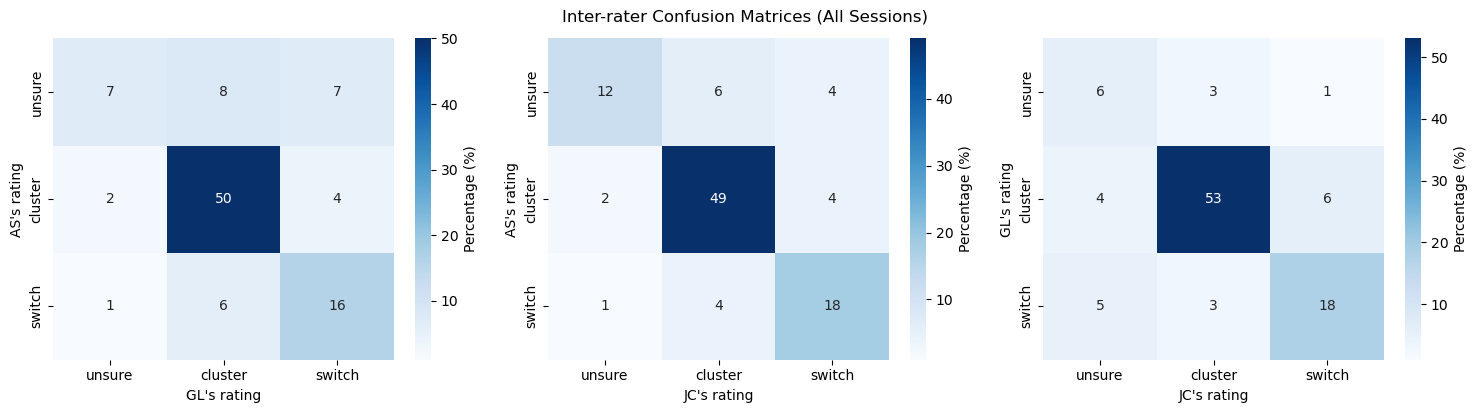

In [32]:
all_ratings = load_all_ratings()
summarize_inter_rater_reliability(all_ratings)

fig = plot_confusion_matrices_all_sessions(all_ratings)
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

#JC: 0-1-2: 15/59/26
#AS: 0-1-2: 22/55/23
#GL: 0-1-2: 10/63/27